# Data Preprocessing

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from plotnine import *
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams['axes.unicode_minus'] = False

In [14]:
class DataPreprocessing:
    
    def __init__(self):
        self.data = None
        
    def input_data(self, data):  
        if isinstance(data, pd.DataFrame):  
            self.data = data  
        else:  
            raise ValueError("Input data must be a pandas DataFrame")  
        
    def load_csv_data(self,path,encode="utf-8"):
        "Read your csv data using several common encoding methods"
        # Try to read the data using the given encoding method
        try:
            self.data = pd.read_csv(path,encoding = encode)
        except UnicodeError:
            if encode != 'utf-8':
                print("Your encoding method have failed!Let's try others.")
            pass
        # Try these common useful encoding methods
        encoding=['utf-16','gb18030','unicode_escape','iso-8859-1', 'cp1252']
        try:
            encoding.remove(encode)
        except:
            pass
        error_count = 0
        for encode in encoding:
            try:
                self.data = pd.read_csv(path,encoding=encode)
                print("We have successfully encoded your data!")
                break
            except UnicodeError: # ignore the encoding error
                error_count += 1
                pass
            except Exception as e: # print the type of other errors
                print(e)
        if error_count == len(encoding):
            print("('utf-8','utf-16','gb18030','unicode_escape','iso-8859-1', 'cp1252') have all failed to read your data!\n\
        Please check your data form or try other encoding methods through the second parameter.")
        return None
    
    def column_selection(self,columns):
        "Get the subdataframe according to your column names list"
        try:
            subdata = self.data.loc[:,columns]
            return subdata
            print("The data have be updated!")
        # If the column names are incorrect then print the false name and let the user input names again
        except KeyError:
            error_col = []
            for col in columns:
                if col in self.data.columns:
                    continue
                else:
                    error_col.append(col)
            print("There are no columns named {} in the data!".format(error_col))
            columns = input("Please check your column names and reset them here:(split with ',')").split(',')
            self.column_selection(columns)
        except Exception as e:
            print(e)
            
    def del_na(self):
        "Delete the rows containing Nan,None and Null"
        try:
            # Replace the null with np.nan  
            self.data = self.data.replace('', np.nan)  
            # Delete the rows  
            self.data = self.data.dropna()
        except Exception as e:
            print(e)
        
    def map_grade(self, grade='grade'):  
        "Map the loan grades A-Z to 0-25"
        gd = {}  
        for i in range(26):  
            gd[chr(i+65)] = i
        self.data[grade] = self.data[grade].map(gd)  
    
    def map_year(self, year='year'):
        "Replace the employmentLength:<1:1,10+:10"
        self.data[year] = self.data[year].map(lambda x: str(x)[:-5])
        self.data.loc[self.data[year]=='< 1', year]=1
        self.data.loc[self.data[year] == '10+ ', year] =10
        self.data[year] = self.data[year].astype('int')
    
    # 将邮政编码前三位数字中所有非3位数字的数据进行剔除，从邮政编码的前3位数字可以提取出该地区所在的省份
    def map_postcode(self, postcode="postCode"):
        "Filter the wrong numbers and map the postcode to province"
        self.data[postcode] = self.data[postcode].astype(str).str.rjust(3,'0')
        self.data[postcode] = self.data[postcode].map(lambda x: str(x)[0:2])
        #self.data.drop(self.data[self.data[postcode]=="na"].index,inplace = True)
        pcd = {'10':"北京市","20":"上海市","30":"天津市","40":"重庆市","01":"内蒙古自治区","02":"内蒙古自治区","03":"山西省","04":"山西省",
               "05":"河北省","06":"河北省","07":"河北省","11":"辽宁省","12":"辽宁省","13":"吉林省","15":"黑龙江省","16":"黑龙江省",
               "17":"山东省","21":"江苏省","22":"江苏省","23":"安徽省","24":"安徽省","25":"山东省","26":"山东省","27":"山东省","31":"浙江省",
               "32":"浙江省","33":"江西省","34":"江西省","35":"福建省","36":"福建省","41":"湖南省","42":"湖南省","43":"湖北省",
               "44":"湖北省","45":"河南省","46":"河南省","47":"河南省","51":"广东省","52":"广东省","53":"广西壮族自治区","54":"广西壮族自治区",
               "55":"贵州省","56":"贵州省","57":"海南省","61":"四川省","62":"四川省","63":"四川省","64":"四川省","65":"海南省",
               "66":"海南省","67":"海南省","70":"陕西省","71":"陕西省","72":"陕西省","73":"甘肃省","74":"甘肃省","75":"宁夏回族自治区","76":"河南省",
               "77":"宁夏省","81":"青海省","82":"陕西省","83":"新疆维吾尔自治区","84":"新疆维吾尔自治区","85":"西藏自治区","86":"西藏自治区"}
        self.data["province"] = self.data[postcode].map(pcd)
        self.data = self.data.drop(postcode,axis=1)
        
    def del_outliers(self,columns,threshold=4):
        "Delete the rows containing outliers according to Chebyshev's Inequality"
        # Create a mask to track rows with outliers
        outlier_mask = np.zeros(len(self.data), dtype=bool)

        # Iterate over specified columns
        for column in columns:
            mean_val = self.data[column].mean()
            std_val = self.data[column].std()

            # Use Chebyshev's Inequality to calculate the minimum and maximum values within the threshold
            min_val = mean_val - threshold * std_val
            max_val = mean_val + threshold * std_val

            # Update the outlier mask for the current column
            outlier_mask |= (self.data[column] < min_val) | (self.data[column] > max_val)
        self.data = self.data[~outlier_mask]

In [15]:
Data = DataPreprocessing()
# Read train data
Data.load_csv_data('train.csv')
# Select the columns with clear meanings
column_names = ['loanAmnt', 'term', 'interestRate', 'installment', 'grade', 'employmentLength',
                'homeOwnership', 'annualIncome', 'purpose', 'postCode', 'dti', 'delinquency_2years', 'isDefault']
df = Data.column_selection(column_names)
df.info()

We have successfully encoded your data!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loanAmnt            800000 non-null  float64
 1   term                800000 non-null  int64  
 2   interestRate        800000 non-null  float64
 3   installment         800000 non-null  float64
 4   grade               800000 non-null  object 
 5   employmentLength    753201 non-null  object 
 6   homeOwnership       800000 non-null  int64  
 7   annualIncome        800000 non-null  float64
 8   purpose             800000 non-null  int64  
 9   postCode            799999 non-null  float64
 10  dti                 799761 non-null  float64
 11  delinquency_2years  800000 non-null  float64
 12  isDefault           800000 non-null  int64  
dtypes: float64(7), int64(4), object(2)
memory usage: 79.3+ MB


In [16]:
# Delete the nan value and update unique columns
Data.input_data(df)
Data.del_na()
Data.map_grade('grade')
Data.map_postcode('postCode')
Data.map_year('employmentLength')
Data.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753188 entries, 0 to 799999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loanAmnt            753188 non-null  float64
 1   term                753188 non-null  int64  
 2   interestRate        753188 non-null  float64
 3   installment         753188 non-null  float64
 4   grade               753188 non-null  int64  
 5   employmentLength    753188 non-null  int64  
 6   homeOwnership       753188 non-null  int64  
 7   annualIncome        753188 non-null  float64
 8   purpose             753188 non-null  int64  
 9   dti                 753188 non-null  float64
 10  delinquency_2years  753188 non-null  float64
 11  isDefault           753188 non-null  int64  
 12  province            543229 non-null  object 
dtypes: float64(6), int64(6), object(1)
memory usage: 80.4+ MB


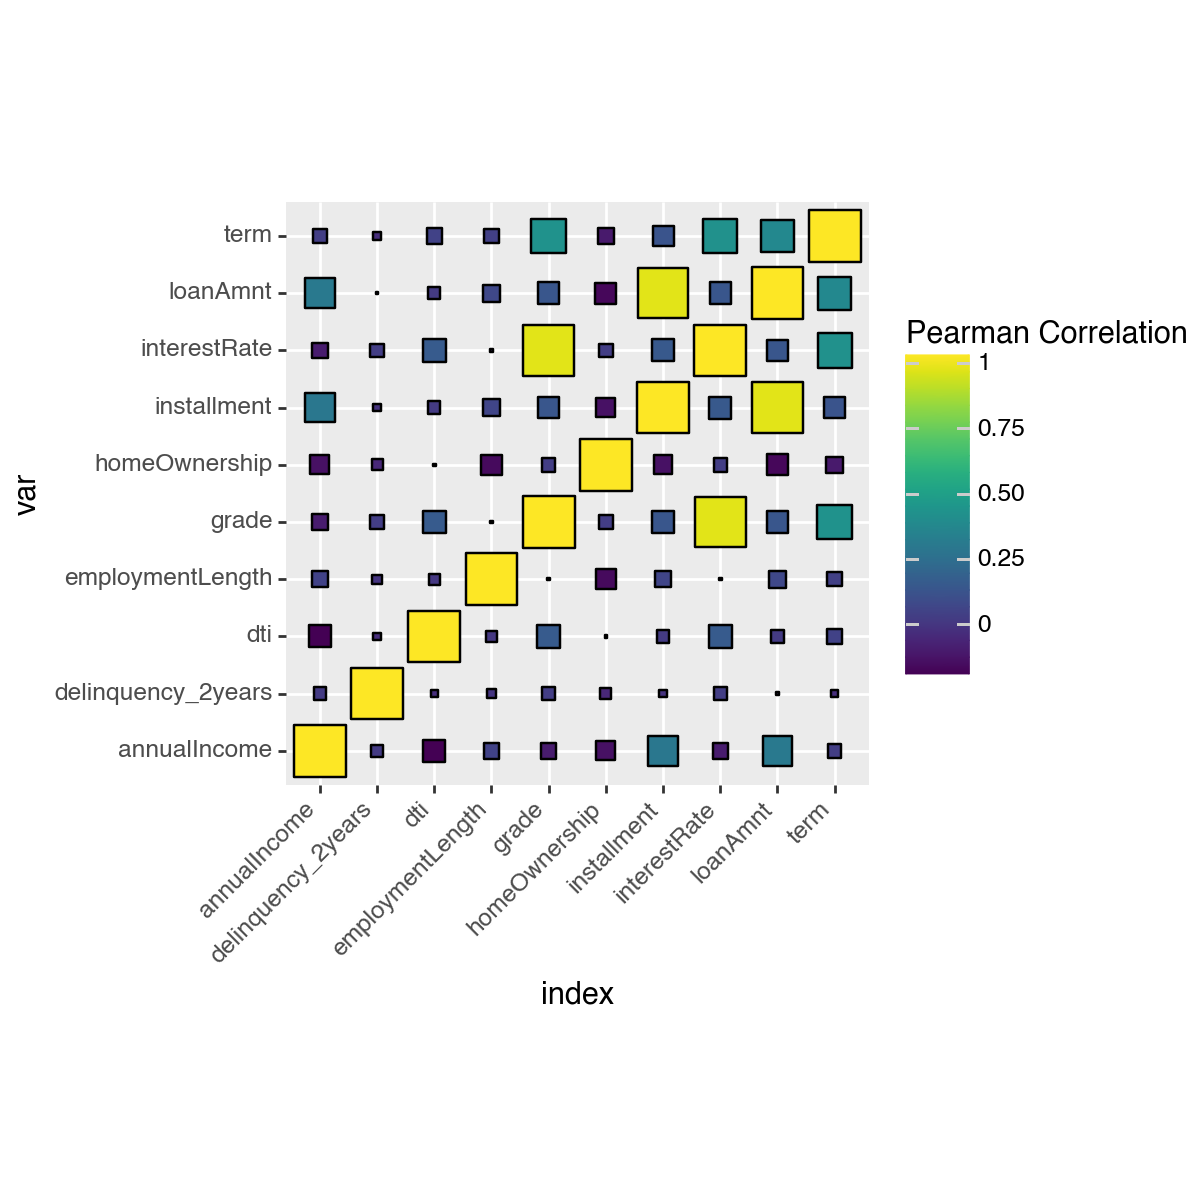

<Figure Size: (600 x 600)>

In [17]:
# Plot the correlation matrix
cols = Data.data.columns
class_col = ['province','purpose','isDefault']
numeric_cols = [i for i in cols if i not in class_col]
data = Data.data.loc[:,numeric_cols]
corr = np.round(data.corr(),2).reset_index()
df2 = pd.melt(corr,id_vars='index',var_name='var',value_name='value')
df2['AbsValue']=np.abs(df2.value)
df2.head()
p = (
    ggplot(df2, aes(x ='index', y ='var', fill = 'value',size='AbsValue')) +  
    geom_point(shape='s',color="black") +
    scale_size_area(max_size=10, guide=False) +
    scale_fill_cmap(name ='Pearman Correlation')+
    coord_equal()+
    theme(dpi=100, figure_size=(6,6))+
    theme(axis_text_x=element_text(angle=45, hjust=1))
)
p

In [7]:
p.save("corr.png",dpi = 800)

In [18]:
# Adjust the variables again according to correlation matrix(delete 'grade' and 'installment')
cols = [i for i in cols if i not in ['grade','installment']]
df = Data.column_selection(cols)
# Update the dataframe and delete the outliers
Data.input_data(df)
cols = [i for i in cols if i is not 'province']
Data.del_outliers(cols,4)
Data.data

,loanAmnt,term,interestRate,employmentLength,homeOwnership,annualIncome,purpose,dti,delinquency_2years,isDefault,province
0,35000.0,5,19.52,2,2,110000.0,1,17.05,0.0,1,吉林省
1,18000.0,5,18.49,5,0,46000.0,0,27.83,0.0,0,黑龙江省
2,12000.0,5,16.99,8,0,74000.0,0,22.77,0.0,0,江西省
3,11000.0,3,7.26,10,1,118000.0,4,17.21,0.0,0,NaN
5,11000.0,3,7.99,7,0,39000.0,9,17.14,0.0,0,广东省
...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14.49,7,1,72000.0,0,19.03,0.0,0,安徽省
799996,17000.0,3,7.90,10,0,99000.0,4,15.72,1.0,0,贵州省
799997,6000.0,3,13.33,10,1,65000.0,0,12.11,1.0,1,河南省
799998,19200.0,3,6.92,10,0,96000.0,4,29.25,0.0,0,江西省


# Visualization

## China Map（Province）

### Delinquency Numbers Map

In [66]:
from pyecharts.charts import Map
from pyecharts import options as opts
from pyecharts.render import make_snapshot
from snapshot_pyppeteer import snapshot
from pyecharts.faker import Faker

In [67]:
data = Data.data.copy()
default = data.groupby('province')['isDefault'].sum()
data_pair = [(i,default[i]/1) for i in default.index]

city_default = (
        Map(init_opts=opts.InitOpts(width="1300px", height="1000px"))
        .add(
                "",
                data_pair,
                maptype='china',
                is_map_symbol_show=True,
            zoom=1.2
                )
        .set_global_opts(
                #title_opts=opts.TitleOpts(title="Number of Delinquency "),
                visualmap_opts=opts.VisualMapOpts(
                        min_=400,
                        max_=8000,
                        range_text = ['Delinquency number intervals:', ''],  #分区间
                        is_piecewise=True,  #定义图例为分段型，默认为连续的图例
                        pos_top= "middle",  #分段位置
                        pos_left="left",
                        orient="vertical",
                        split_number=10  #分成10个区间
                        #type_="color",
                        ),))

city_default.render("delinquency_number.html") 

'/Users/christine/Desktop/研一上/编程基础/Final project/delinquency_number.html'

In [68]:
make_snapshot(snapshot, city_default.render(), "delinquency_number.png", notebook=True)

### Delinquenct Probability Map

In [69]:
num = pd.DataFrame(data.groupby('province')['isDefault'].count())
default = pd.DataFrame(default)
prob = default['isDefault']/num['isDefault']

In [70]:
prob_pair = [(i,prob[i]/1) for i in prob.index]

city_default = (
        Map(init_opts=opts.InitOpts(width="1300px", height="1000px"))
        .add(
                "",
                prob_pair,
                maptype='china',
                is_map_symbol_show=True,
            zoom = 1.2
                )
    
        .set_global_opts(
                #title_opts=opts.TitleOpts(title="Probability of Delinquency"),
                visualmap_opts=opts.VisualMapOpts(
                        min_=0.16,
                        max_=0.22,
                        range_text = ['Delinquency probability intervals:', ''],  #分区间
                        is_piecewise=True,  #定义图例为分段型，默认为连续的图例
                        pos_top= "middle",  #分段位置
                        pos_left="left",
                        orient="vertical",
                        split_number=10  #分成10个区间
                        #type_="color",
                        ),))

city_default.render("delinquency_porbability.html")

'/Users/christine/Desktop/研一上/编程基础/Final project/delinquency_porbability.html'

In [71]:
make_snapshot(snapshot, city_default.render(), "delinquency_porbability.png", notebook=True) 

## Visualization in classification variables（purpose）

In [15]:
import warnings
warnings.filterwarnings("ignore")

data = Data.data.copy()
# integrate the purposes into 999 if its proportion is too small
l0 = [0,2,4,5]
dic = {}
for i in range(12):
    if i in l0:
        dic[i] = i
    else:
        dic[i] = 999
data["purpose"] = data["purpose"].map(dic)

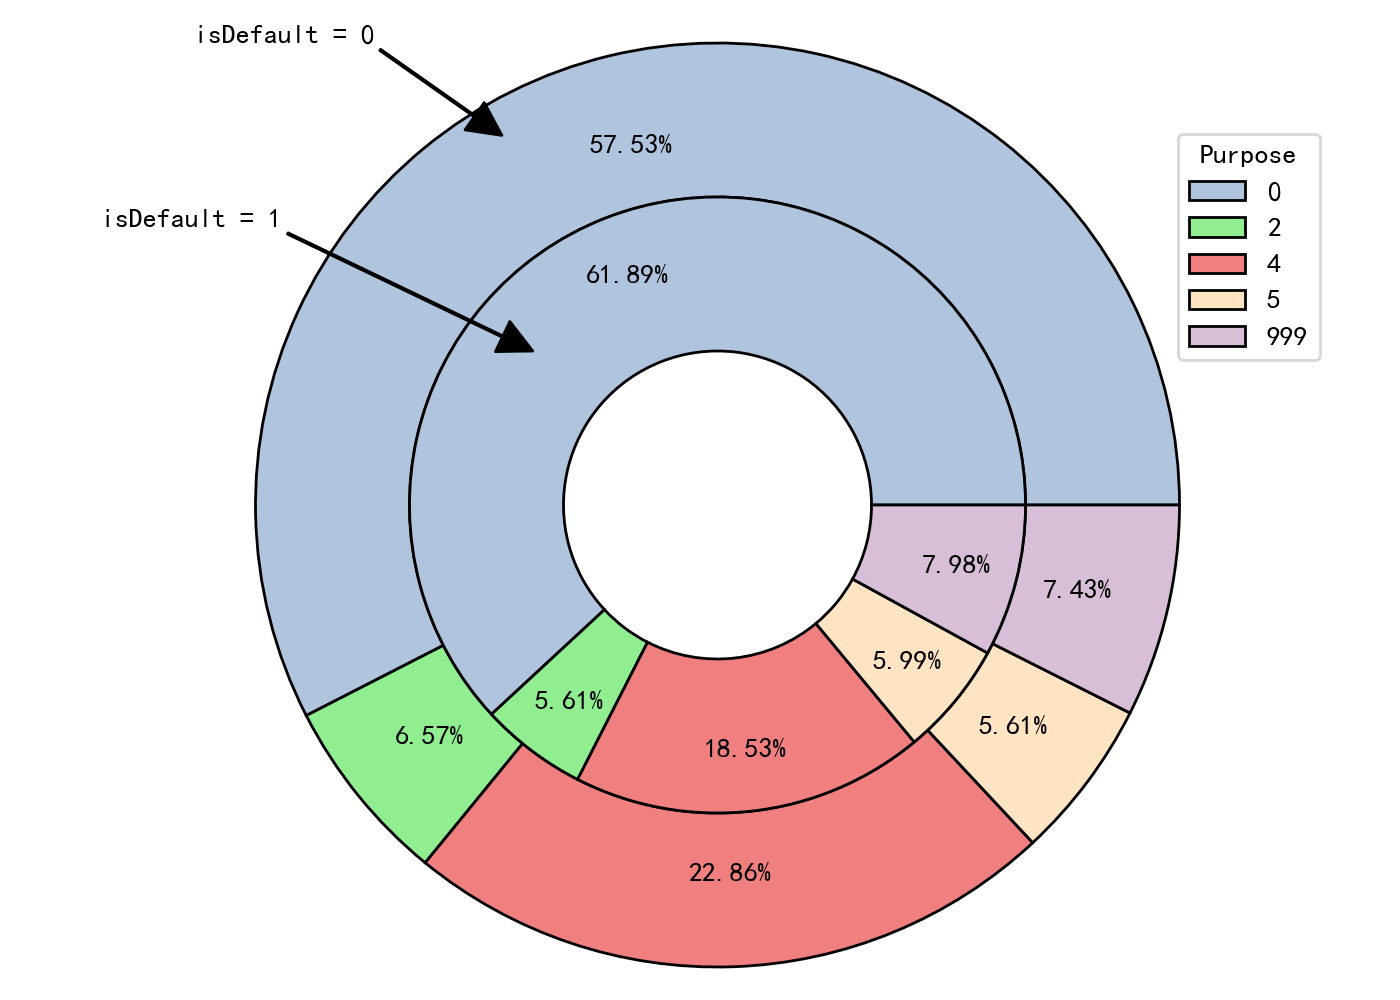

In [16]:
# Ring plot of "purpose" according to "isDefault"
d0 = data.loc[data["isDefault"]==0,"purpose"].value_counts().sort_index()
d1 = data.loc[data["isDefault"]==1,"purpose"].value_counts().sort_index()
plt.figure(figsize = (7,5))
color = ["lightsteelblue","lightgreen","lightcoral","bisque","thistle"]
wp = {'linewidth': 1, 'edgecolor':'black','width': 0.5}
plt.pie(d0,radius = 1.5,autopct = "%.2f%%",pctdistance = 0.8,wedgeprops = wp,colors = color)
plt.pie(d1,radius = 1.0,autopct = "%.2f%%",pctdistance = 0.8,wedgeprops = wp,colors = color)
plt.annotate("isDefault = 0",xy = (-0.7,1.2),xytext = (-1.7,1.5),arrowprops = dict(facecolor = "black",width = 0.5,frac = 0.1))
plt.annotate("isDefault = 1",xy = (-0.6,0.5),xytext = (-2,0.9),arrowprops = dict(facecolor="black",width=0.5,frac=0.1))
label = d0.index
plt.legend(label,title = "Purpose",loc = "upper right",bbox_to_anchor=(1.3,1))
plt.savefig("plot1.png",dpi = 500)
plt.show()

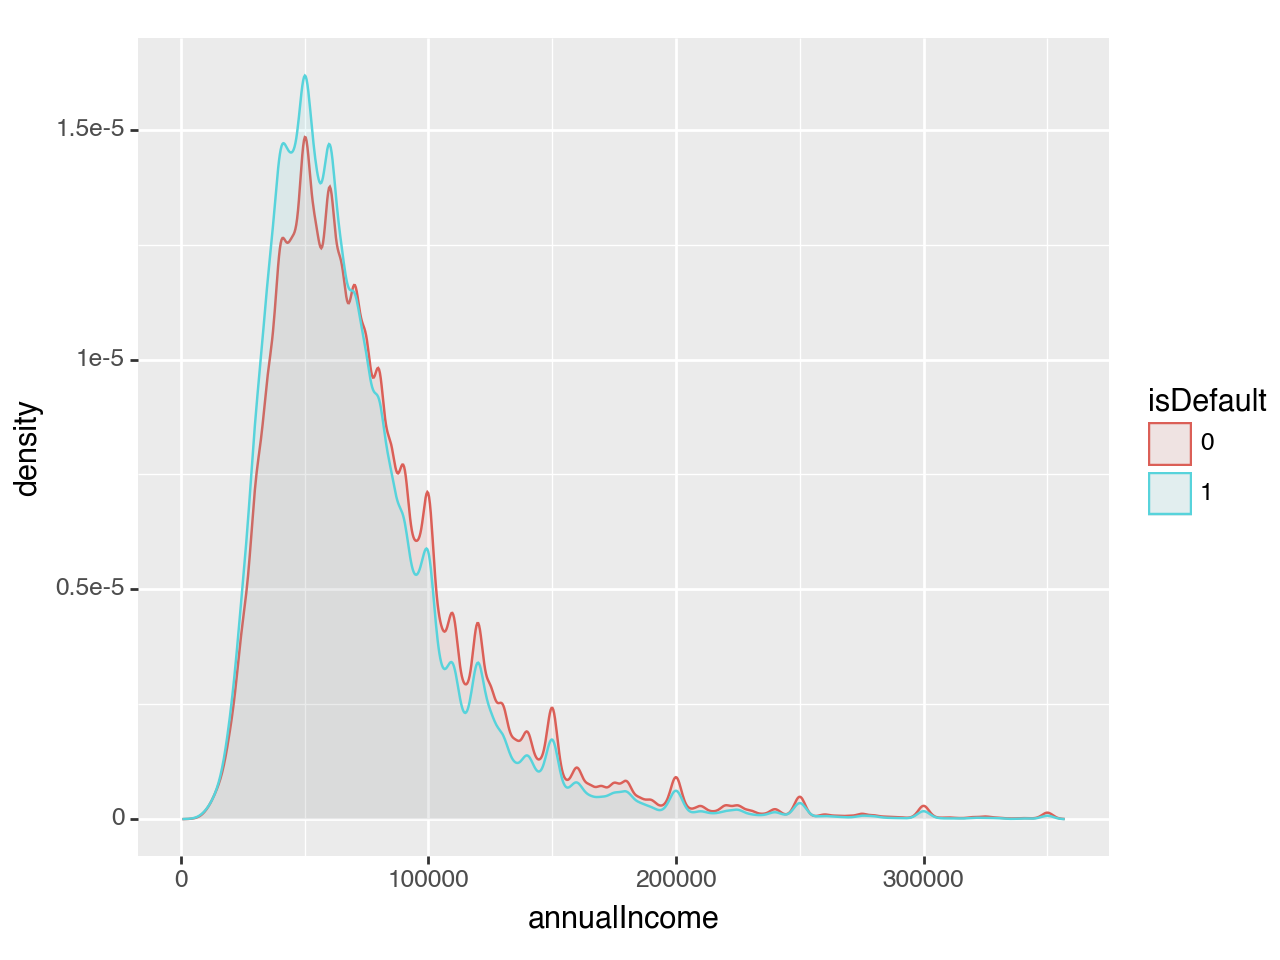

<Figure Size: (640 x 480)>

In [17]:
data['isDefault'] = data['isDefault'].astype(str)
p = (
    ggplot(data, aes(x='annualIncome',color = 'isDefault',fill = 'isDefault'))
    + geom_density(alpha=0.1)
)
p

In [18]:
p.save('plot2.png',dpi = 200)

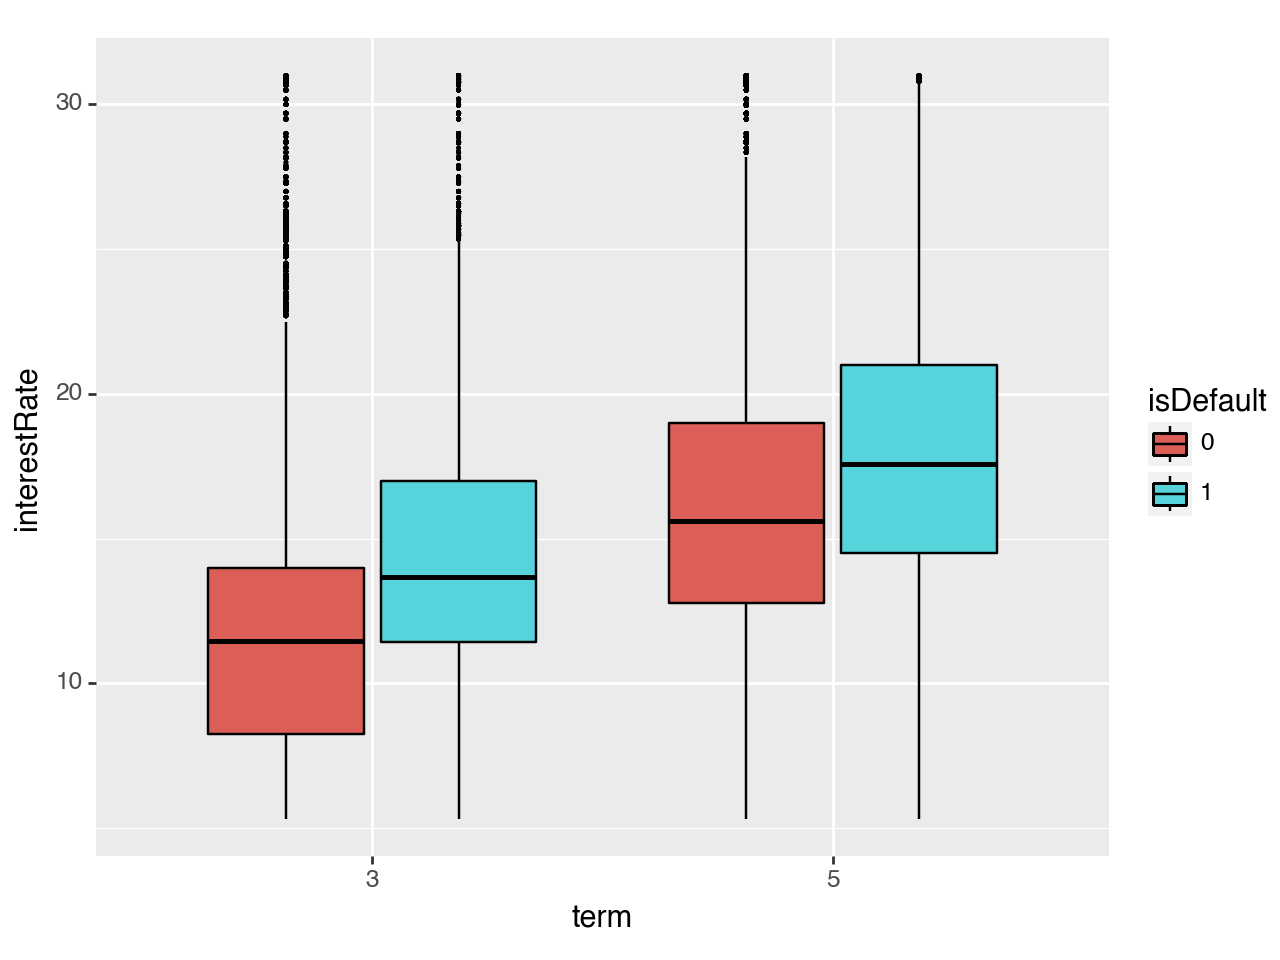

<Figure Size: (640 x 480)>

In [19]:
data['homeOwnership'] = data['homeOwnership'].astype(str)
data['employmentLength'] = data['employmentLength'].astype(str)
data['term'] = data['term'].astype(str)
p = (
    ggplot(data, aes(x='term', y='interestRate', fill='isDefault'))
    + geom_boxplot(outlier_size=0, color='k')
)
p

In [20]:
p.save('plot3.png',dpi = 200)

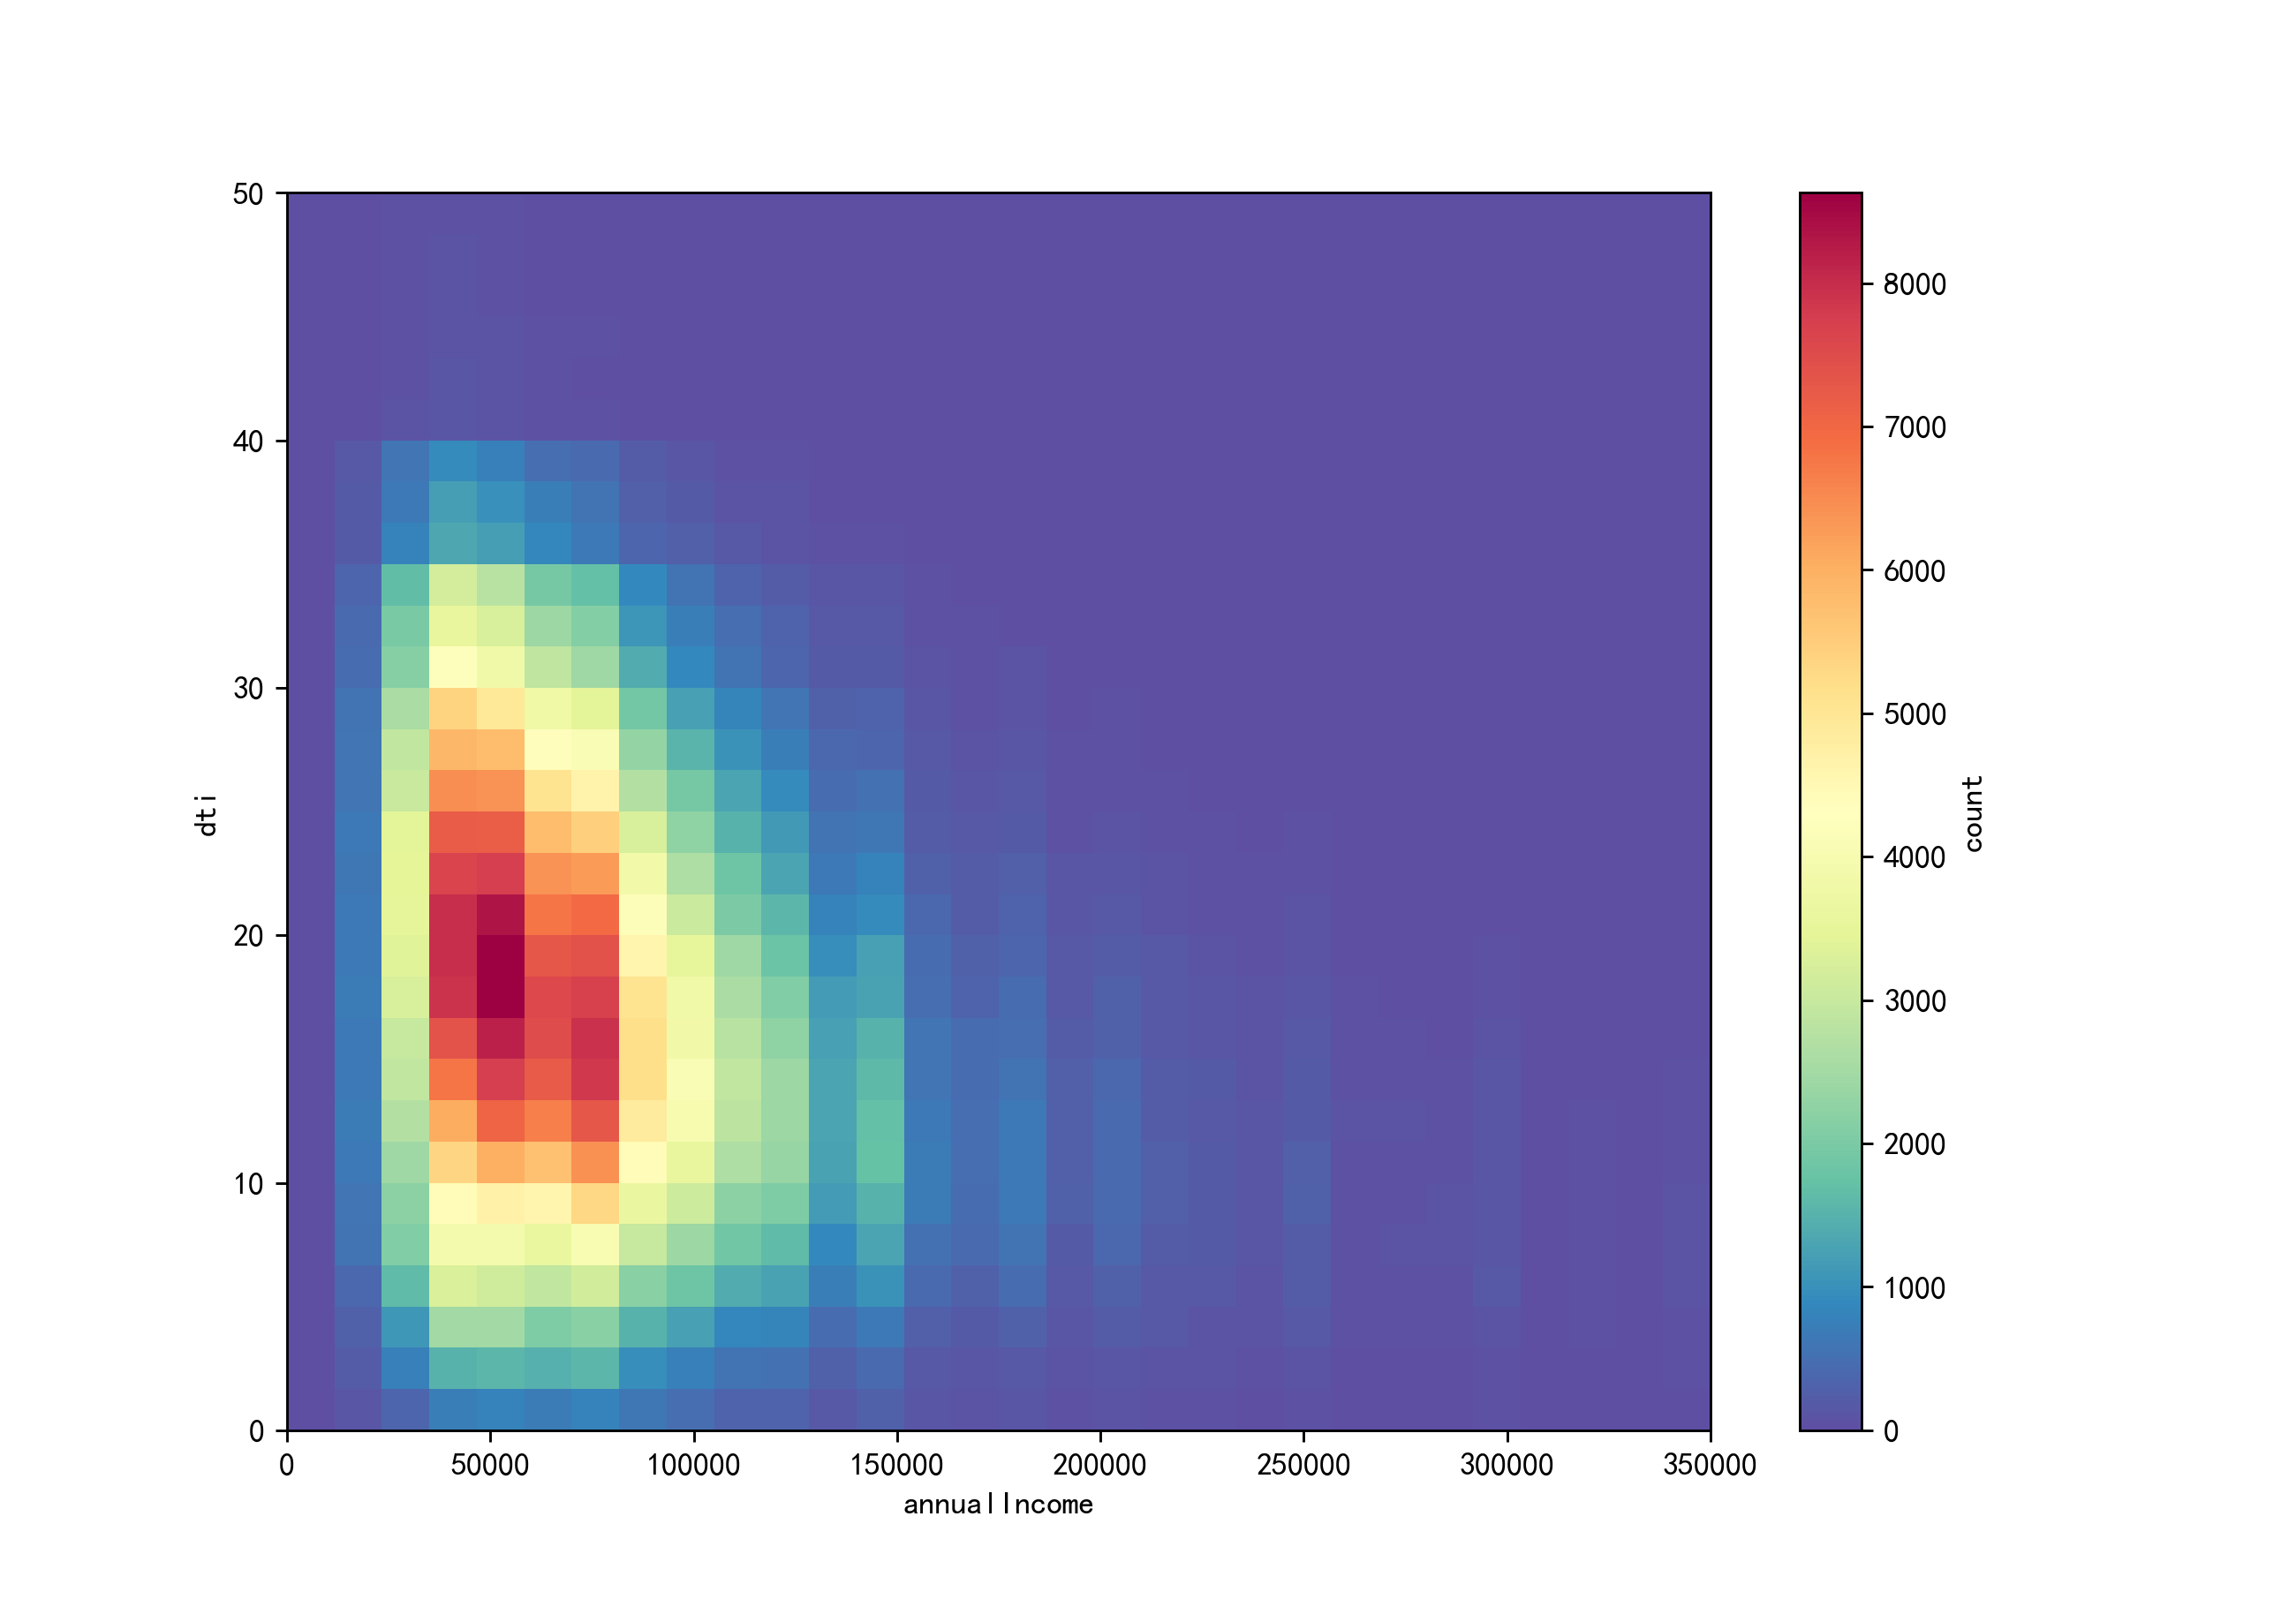

In [21]:
#矩形二维统计直方图
fig = plt.figure(figsize=[10,7],dpi=130)
h=plt.hist2d(data['annualIncome'], data['dti'],bins=30,range=[[0,350000],[0,50]],cmap=plt.cm.Spectral_r)

ax=plt.gca()
ax.set_xlabel('annualIncome')
ax.set_ylabel('dti')
cbar=plt.colorbar(h[3])
cbar.set_label('count')
plt.savefig('plot4.png',dpi = 500)
plt.show()

In [87]:
data['delinquency_2years'] = data['delinquency_2years'].astype(int).astype(str)
data['isDefault'] = data['isDefault'].astype(str)
data['employmentLength'] = data['employmentLength'].astype(str)
data['homeOwnership'] = data['homeOwnership'].astype(str)


df = data.groupby(['isDefault','delinquency_2years'])['term'].count().unstack()
sum_del = df.apply(lambda x: x.sum(), axis=0)
df = df.apply(lambda x: x/sum_del,axis=1)
mydata = df.stack().reset_index()
mydata.columns = ['isDefault', 'Delinquency in 2 years', 'percentage']
mydata

,isDefault,Delinquency in 2 years,percentage
0,0,0,0.808216
1,0,1,0.795428
2,0,2,0.779974
3,0,3,0.774003
4,1,0,0.191784
5,1,1,0.204572
6,1,2,0.220026
7,1,3,0.225997


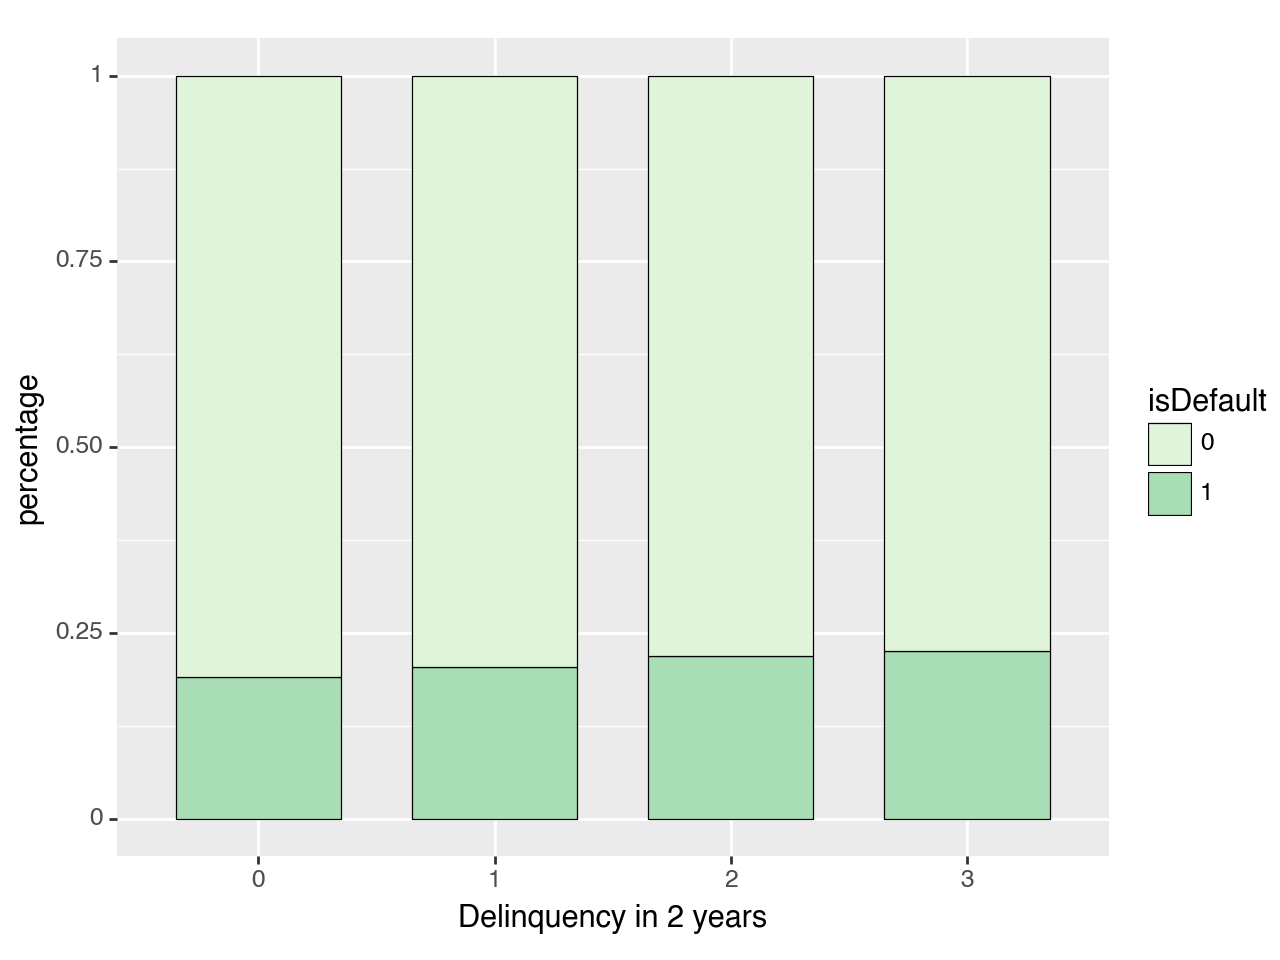

<Figure Size: (640 x 480)>

In [88]:
p = (
    ggplot(mydata, aes(x='Delinquency in 2 years', y='percentage', fill='isDefault'))
    + geom_bar(stat='identity', color='k', position='fill', width=0.7, size=0.25)
    + scale_fill_brewer(palette='GnBu')
)
p

In [ ]:
p.save('plot5.png',dpi = 300)

In [90]:
df = data.groupby(['isDefault','homeOwnership'])['term'].count().unstack()
sum_del = df.apply(lambda x: x.sum(), axis=0)
df = df.apply(lambda x: x/sum_del,axis=1)
mydata = df.stack().reset_index()
mydata.columns = ['isDefault', 'Home Ownership', 'percentage']
mydata

,isDefault,Home Ownership,percentage
0,0,0,0.832052
1,0,1,0.773065
2,0,2,0.799254
3,0,3,0.788235
4,1,0,0.167948
5,1,1,0.226935
6,1,2,0.200746
7,1,3,0.211765


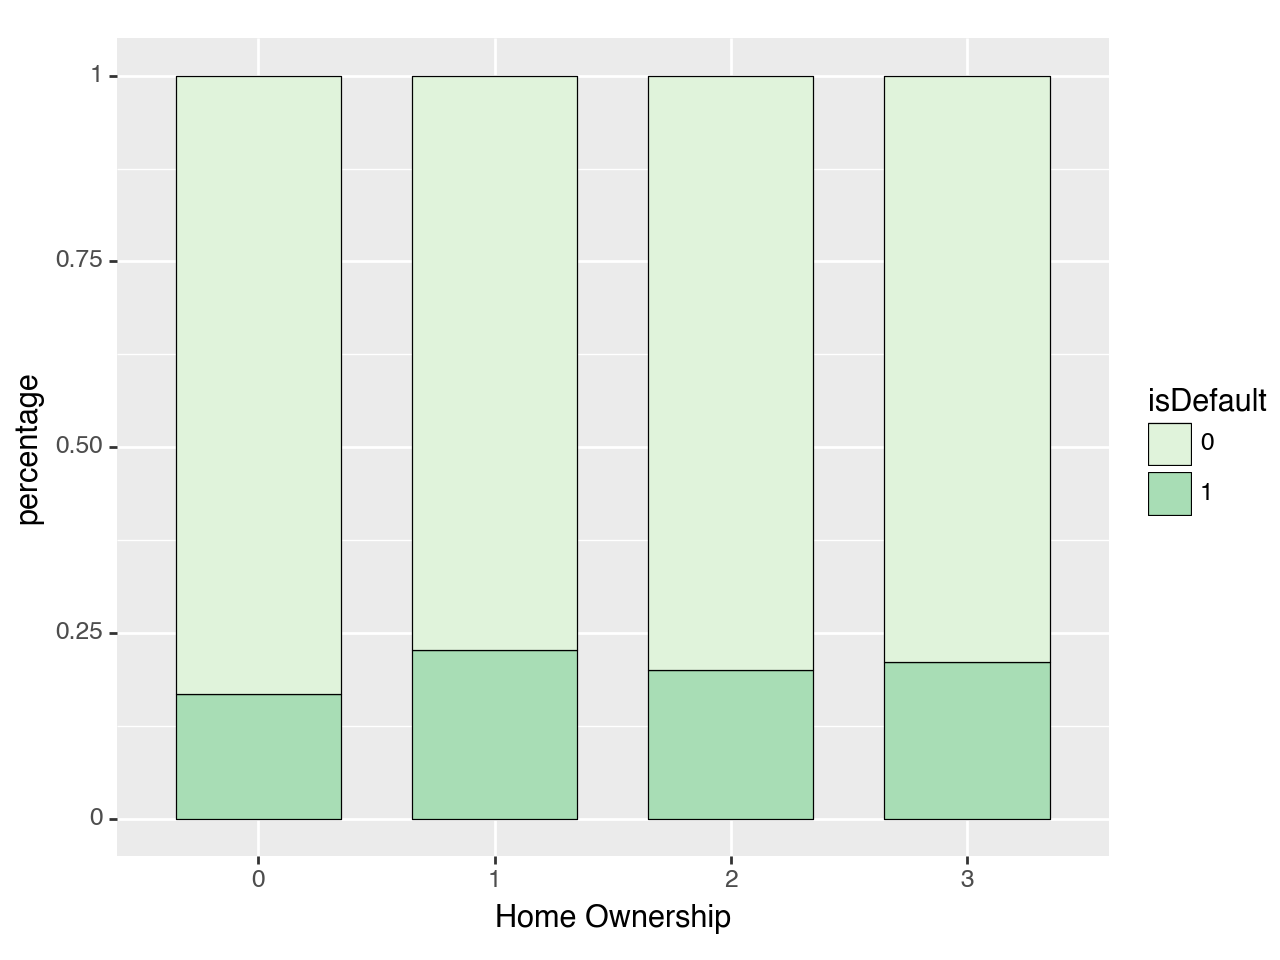

<Figure Size: (640 x 480)>

In [91]:
p = (
    ggplot(mydata, aes(x='Home Ownership', y='percentage', fill='isDefault'))
    + geom_bar(stat='identity', color='k', position='fill', width=0.7, size=0.25)
    + scale_fill_brewer(palette='GnBu')
)
p

In [92]:
p.save('plot7.png',dpi = 300)

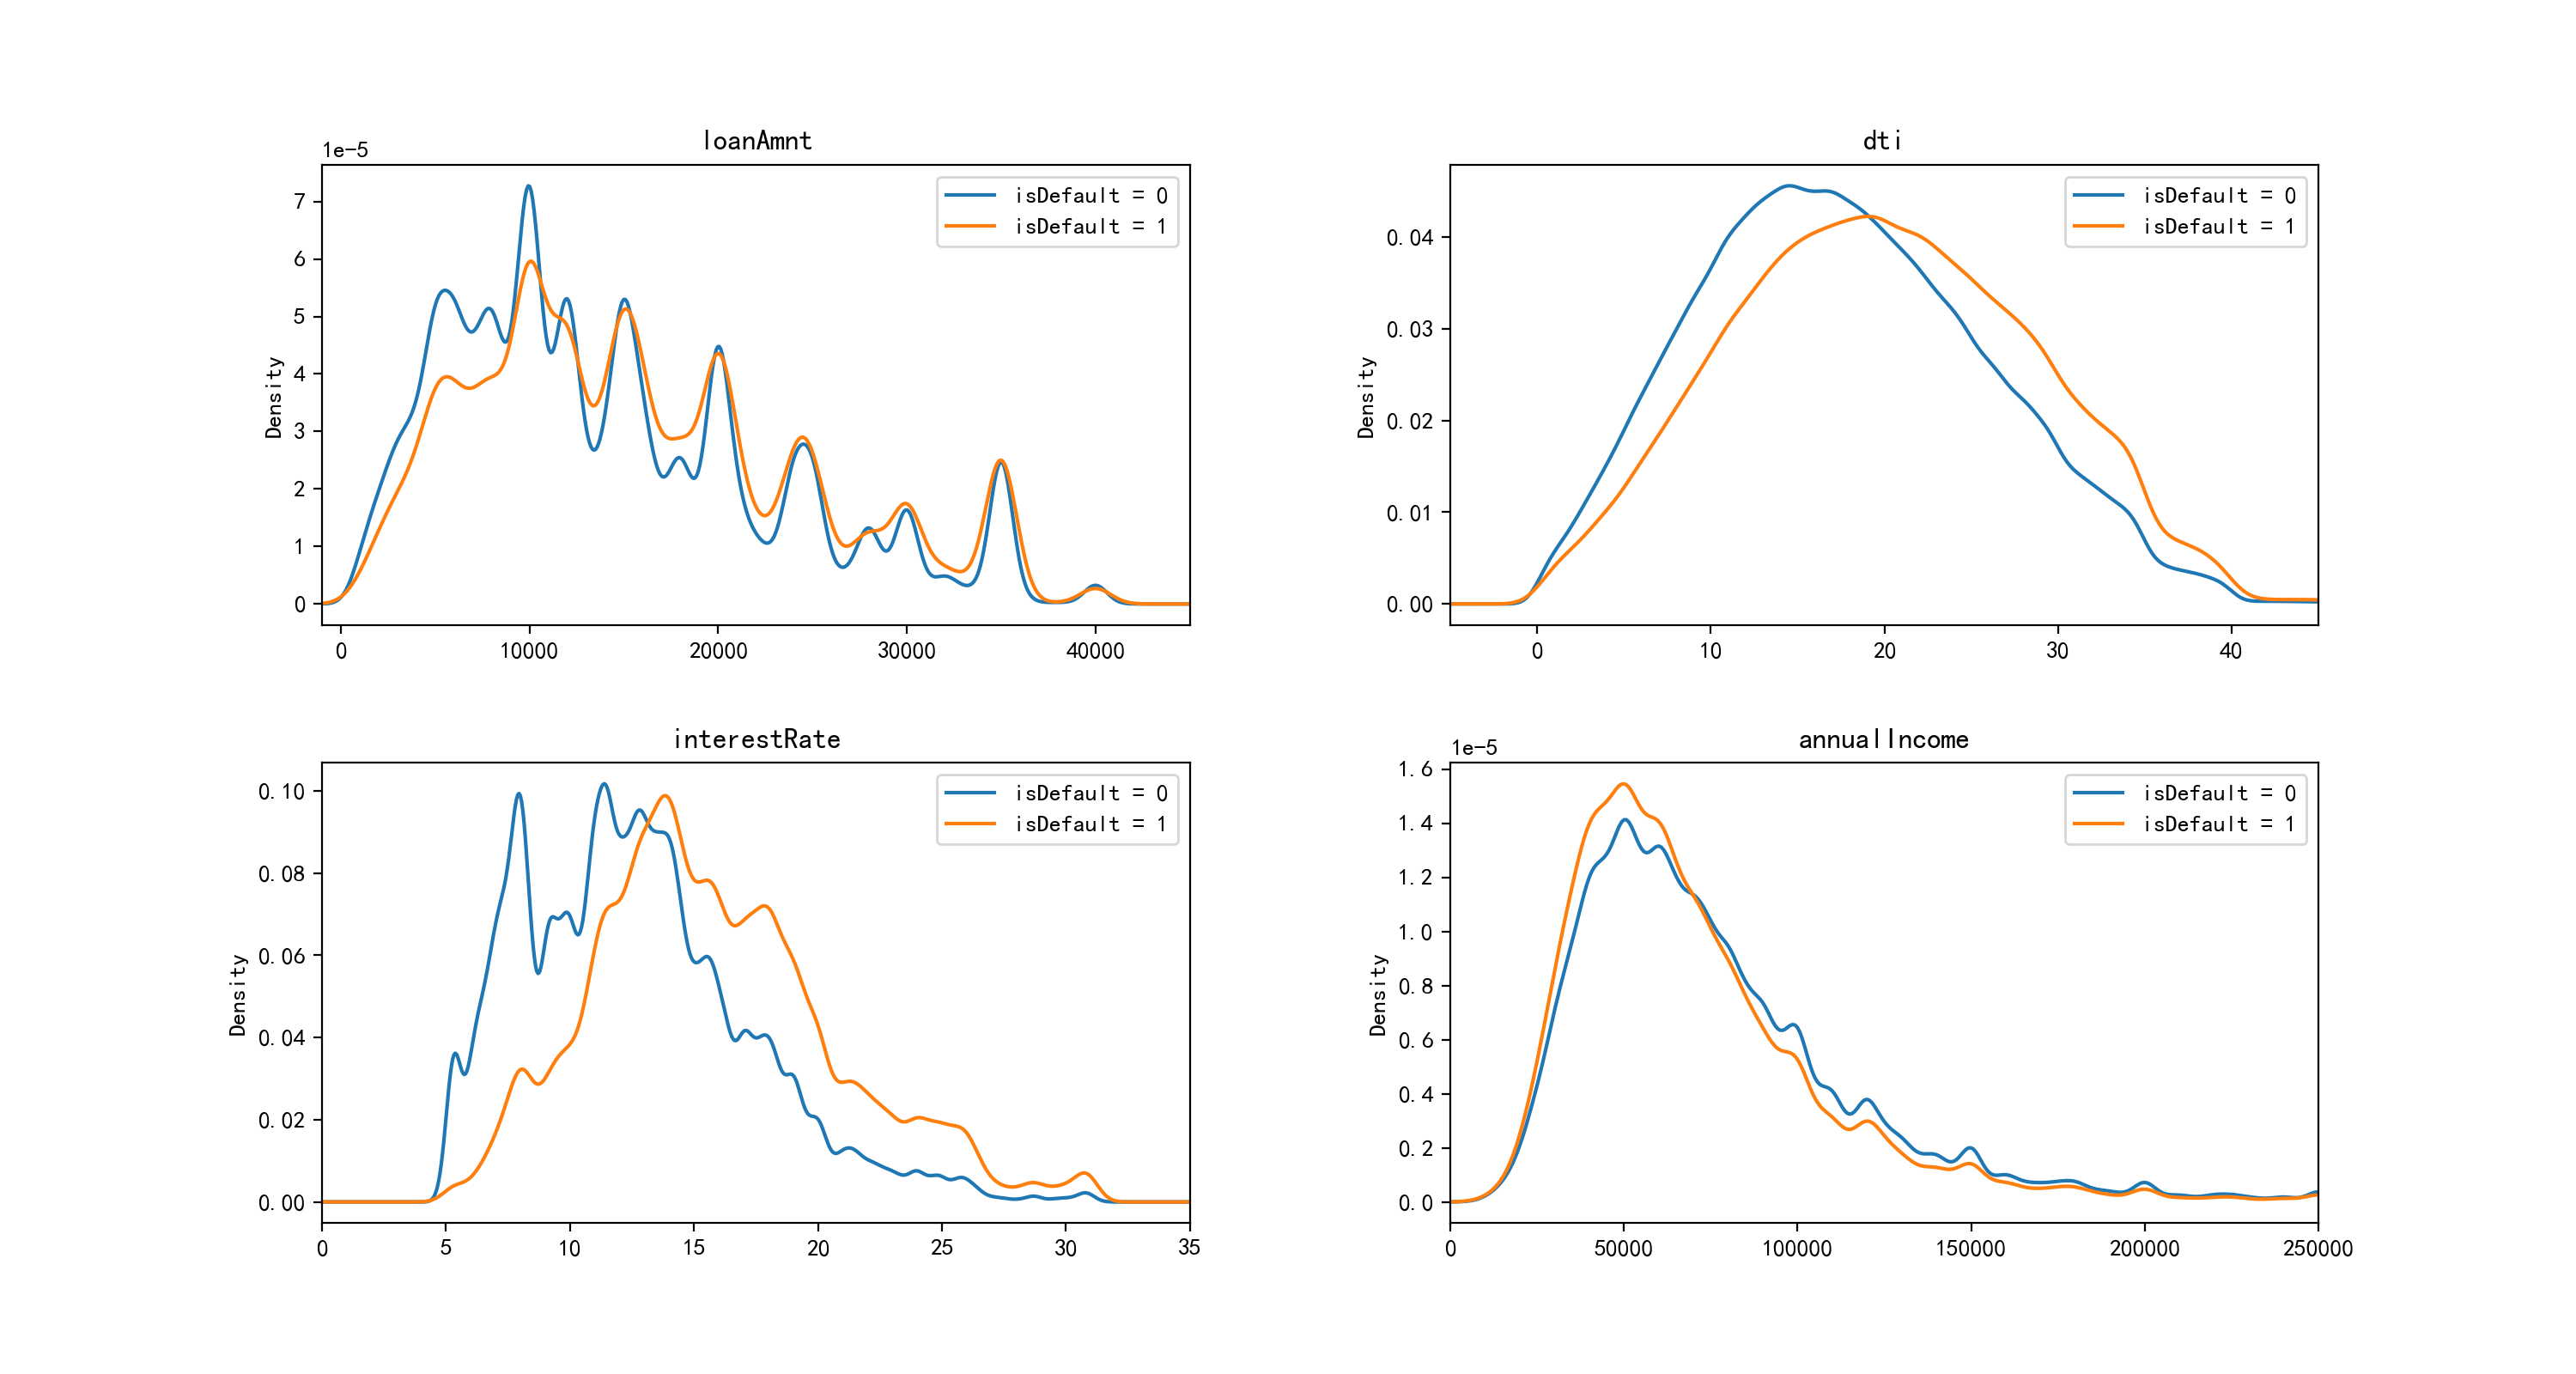

In [25]:
#连续型变量:贷款金额loanAmnt;债务收入比dti;贷款利率interestRate;分期付款金额installment

df0 = data.loc[data["isDefault"]=='0',:]
df1 = data.loc[data["isDefault"]=='1',:]

#sns.kdeplot(df0['loanAmnt'],label = "0")
plt.figure(figsize = (15,8))

plt.subplot(221)
df0['loanAmnt'].plot(kind = "kde",label = "isDefault = 0")
df1["loanAmnt"].plot(kind = "kde",label = "isDefault = 1")
plt.title("loanAmnt")
plt.xlim([-1000,45000])
plt.grid(False)
plt.legend()

plt.subplot(222)
df0["dti"].plot(kind = "kde",label = "isDefault = 0")
df1["dti"].plot(kind = "kde",label = "isDefault = 1")
plt.title("dti")
plt.xlim([-5,45])
plt.grid(False)
plt.legend()

plt.subplot(223)
df0["interestRate"].plot(kind = "kde",label = "isDefault = 0")
df1["interestRate"].plot(kind = "kde",label = "isDefault = 1")
plt.title("interestRate")
plt.xlim([0,35])
plt.grid(False)
plt.legend()

plt.subplot(224)
df0["annualIncome"].plot(kind = "kde",label = "isDefault = 0")
df1["annualIncome"].plot(kind = "kde",label = "isDefault = 1")
plt.title("annualIncome")
plt.xlim([0,250000])
plt.grid(False)
plt.legend()


plt.subplots_adjust(wspace = 0.3,hspace = 0.3)
plt.savefig("plot6.png")
plt.show()

# Model Construction

## Preliminary Model Construction 

In [19]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split#分割训练集和测试集
from sklearn.neighbors import KNeighborsClassifier#k近邻
from sklearn.linear_model import LogisticRegression#逻辑回归
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, recall_score, make_scorer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler#标准化
from sklearn.metrics import accuracy_score#评价指标 accuracy
from sklearn.metrics import classification_report,confusion_matrix#评价指标 混淆矩阵
from sklearn.model_selection import GridSearchCV#参数优化，交叉验证
import matplotlib.pyplot as plt#画图
import warnings#忽视红色警告,'employmentTitle'
warnings.filterwarnings('ignore')

In [21]:
class ModelEvaluation():
    def __init__(self,model,x_train,y_train):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        
    def evaluation(self,x_test,y_test):
        if self.model is None:
            raise ValueError("The model has not been initialized or is set to None.")
        if not hasattr(self.model, 'fit'):
            raise AttributeError("The provided model does not have a fit method.")
        self.model = self.model.fit(self.x_train,self.y_train)
        y_pred = self.model.predict(x_test)
        y_prob = self.model.predict_proba(x_test)[:,1]
        accuracy = accuracy_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        auc = roc_auc_score(y_test,y_prob)
        print('Accuracy:','%.2f'%(accuracy*100)+'%')
        print("Recall:",recall)
        print("AUC:",auc)
        return accuracy,recall,auc

In [22]:
data = Data.data.copy()
# gain labels
y = data['isDefault']
# map "purpose" to less types
l0 = [0,2,4,5]
dic = {}
for i in range(12):
    if i in l0:
        dic[i] = i
    else:
        dic[i] = 999
data["purpose"] = data["purpose"].map(dic)
data = data.iloc[:,:-2]
# Unique thermal coding of unique classified variables
X = pd.get_dummies(data,columns = ['purpose'])
X

,loanAmnt,term,interestRate,employmentLength,homeOwnership,annualIncome,dti,delinquency_2years,purpose_0,purpose_2,purpose_4,purpose_5,purpose_999
0,35000.0,5,19.52,2,2,110000.0,17.05,0.0,False,False,False,False,True
1,18000.0,5,18.49,5,0,46000.0,27.83,0.0,True,False,False,False,False
2,12000.0,5,16.99,8,0,74000.0,22.77,0.0,True,False,False,False,False
3,11000.0,3,7.26,10,1,118000.0,17.21,0.0,False,False,True,False,False
5,11000.0,3,7.99,7,0,39000.0,17.14,0.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,25000.0,3,14.49,7,1,72000.0,19.03,0.0,True,False,False,False,False
799996,17000.0,3,7.90,10,0,99000.0,15.72,1.0,False,False,True,False,False
799997,6000.0,3,13.33,10,1,65000.0,12.11,1.0,True,False,False,False,False
799998,19200.0,3,6.92,10,0,96000.0,29.25,0.0,False,False,True,False,False


In [23]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 500)
EvaluationDF = pd.DataFrame(np.zeros([4,3]))
EvaluationDF.columns = ['Accuracy',"Recall","AUC"]

### Naive Bayes

In [24]:
model_bayes = GaussianNB()
eva_bayes = ModelEvaluation(model_bayes,x_train,y_train)
EvaluationDF.iloc[0,:] = eva_bayes.evaluation(x_test,y_test)

Accuracy: 79.85%
Recall: 0.13478970583127844
AUC: 0.688082613195119


### KNN

In [25]:
model_knn = KNeighborsClassifier(n_neighbors=5)
eva_knn = ModelEvaluation(model_knn,x_train,y_train)
EvaluationDF.iloc[1,:] = eva_knn.evaluation(x_test,y_test)

Accuracy: 77.70%
Recall: 0.11554891813982565
AUC: 0.5790686136601498


### Logistic Regression

In [26]:
model_logistic = LogisticRegression(random_state=2023)
eva_logistic = ModelEvaluation(model_logistic,x_train,y_train)
EvaluationDF.iloc[2,:] = eva_logistic.evaluation(x_test,y_test)

Accuracy: 80.41%
Recall: 0.005973674156913139
AUC: 0.5766780767027513


### Decision Tree 

In [27]:
model_dt = DecisionTreeClassifier()
eva_dt = ModelEvaluation(model_dt,x_train,y_train)
EvaluationDF.iloc[3,:] = eva_dt.evaluation(x_test,y_test)

Accuracy: 70.23%
Recall: 0.28420102108151285
AUC: 0.5439311914635049


In [55]:
EvaluationDF.columns = ['Accuracy', 'Recall', 'AUC']
EvaluationDF['Model'] = ['Bayes','KNN','Logistic','DecisionTree']
third_row = EvaluationDF.iloc[2:3]
df_new = EvaluationDF.drop(EvaluationDF.index[2]).reset_index(drop=True)
EvaluationDF = pd.concat([third_row, df_new], ignore_index=True)

In [56]:
EvaluationDF['Score'] = 0.4*EvaluationDF['Recall']+0.3*EvaluationDF['Accuracy']+0.3*EvaluationDF['AUC']
EvaluationDF

,Accuracy,Recall,AUC,Model,Score
0,0.804081,0.005974,0.576678,Logistic,0.416617
1,0.798529,0.134790,0.688083,Bayes,0.499899
2,0.777046,0.115549,0.579069,KNN,0.453054
3,0.702274,0.284201,0.543931,DecisionTree,0.487542


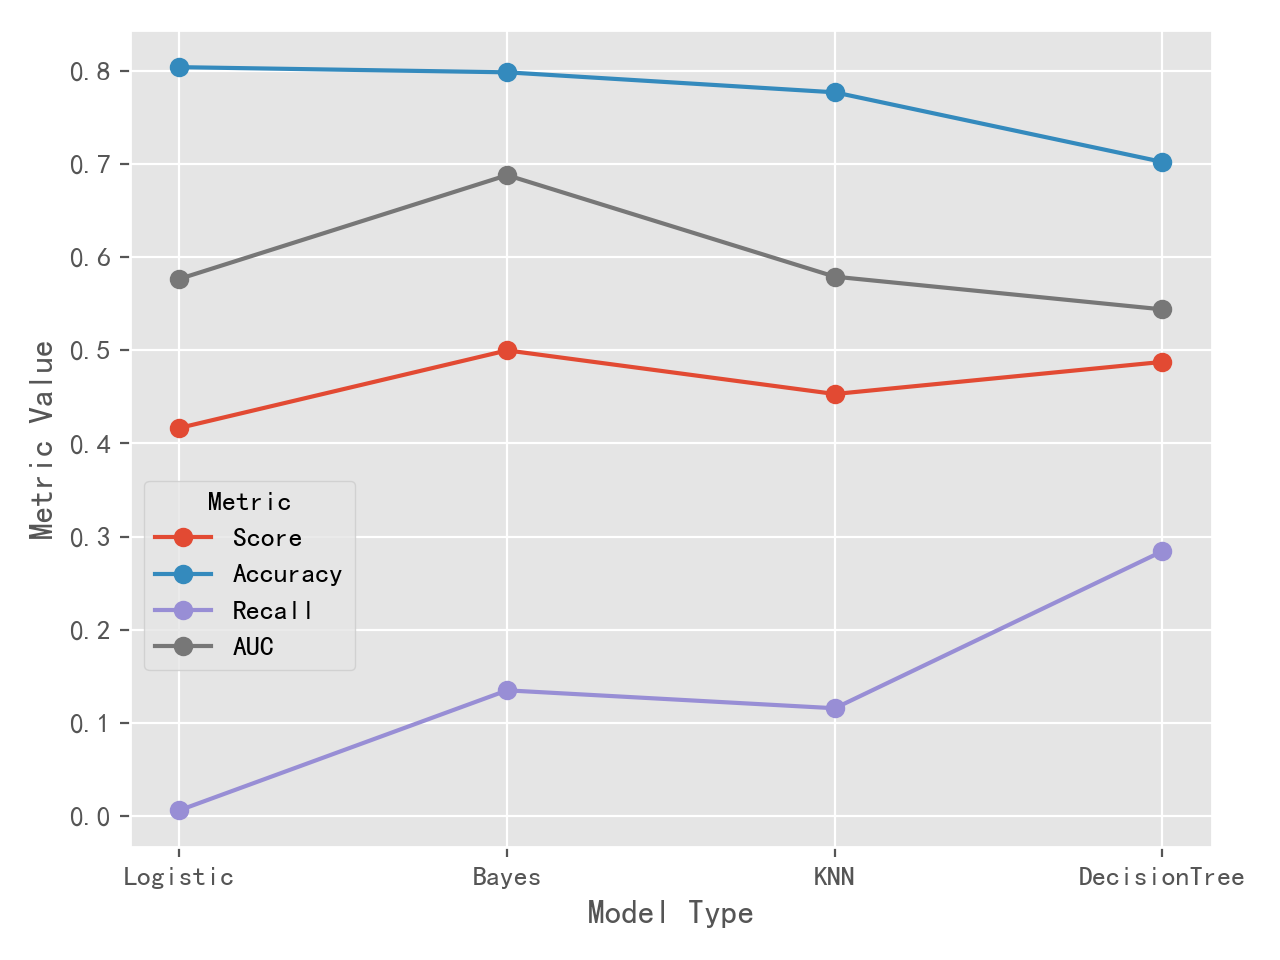

In [57]:
df_long = pd.melt(EvaluationDF, id_vars='Model', value_vars=['Score','Accuracy', 'Recall', 'AUC',], 
                  var_name='Metric', value_name='Value')
plt.style.use('ggplot')

for metric in df_long['Metric'].unique():
    subset = df_long[df_long['Metric'] == metric]
    plt.plot(subset['Model'], subset['Value'], marker='o', label=metric)
    
    if metric == 'FinalScore':
        for index, row in subset.iterrows():
            plt.annotate(f"{row['Value']:.2f}", 
                         (row['Model'], row['Value']), 
                         textcoords="offset points", # 相对位置
                         xytext=(0,8), # 文本的位置偏移
                         ha='center', # 水平对齐
                         fontsize=9)
plt.legend(title='Metric', loc='lower left', bbox_to_anchor=(0, 0.2))
plt.xlabel('Model Type')
plt.ylabel('Metric Value')
plt.savefig('plot8.png', dpi=300)
plt.tight_layout()
plt.show()

## Model Optimization

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer
import time

In [33]:
class ModelOptimizer(ModelEvaluation):
    def __init__(self,model,x_train,y_train,model_type='knn'):
        super().__init__(model,x_train,y_train)
        self.model_type = model_type

    def hyperparameter_tuning(self,param_grid):
        recall_scorer = make_scorer(recall_score)
        grid_search = GridSearchCV(self.model, param_grid, scoring = recall_scorer,cv=5)
        grid_search.fit(self.x_train, self.y_train)
        best_params = grid_search.best_params_
        self.model = self._create_model(best_params)

    def ensemble(self,n_estimators):
        t0 = time.time()
        ensemble_results = [0]
        best_n = 0
        best_ensemble_model = None
        recall_scorer = make_scorer(recall_score)
        for n in n_estimators:
            ensemble_model = BaggingClassifier(base_estimator=self.model, n_estimators=n)
            ensemble_score = cross_val_score(ensemble_model, self.x_train, self.y_train, cv=5, scoring=recall_scorer).mean()
            if ensemble_score > max(ensemble_results):
                best_ensemble_model = ensemble_model
                best_n = n
            ensemble_results.append(ensemble_score)
        t1 = time.time()
        print("Spent Time:",str(t1-t0)[:6])
        print("The best n:",best_n)
        self.model = best_ensemble_model
    
    def _create_model(self, params=None):
        try:
            if self.model_type == 'knn':
                return KNeighborsClassifier(**params) if params else KNeighborsClassifier()
            elif self.model_type == 'logistic':
                return LogisticRegression(**params) if params else LogisticRegression()
            elif self.model_type == 'naive_bayes':
                return GaussianNB(**params) if params else GaussianNB()
            elif self.model_type == 'decision_tree':
                return DecisionTreeClassifier(**params) if params else DecisionTreeClassifier()
            else:
                raise ValueError("Invalid model type. Choose 'knn', 'logistic', 'naive_bayes', or 'decision_tree'.")
        except Exception as e:
            print("An error occurred while creating the model:", str(e))
            return None
        
    def _weighted_scoring(self, y_true, y_pred, X):
        acc = accuracy_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        auc = roc_auc_score(y_true, self.model.predict_proba(X)[:, 1])
        return 0.3 * acc + 0.4 * rec + 0.3 * auc


In [30]:
# Standardize the numeric variables
numeric_cols = ['loanAmnt','interestRate','employmentLength','homeOwnership','annualIncome','dti','delinquency_2years']
scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_test_scaled[numeric_cols] = scaler.fit_transform(x_test[numeric_cols])
# Creat three DataFrame to save the model performance
scaled_eva = pd.DataFrame(np.zeros([4,3]),columns = ['Accuracy',"Recall","AUC"])
paratuning_eva = pd.DataFrame(np.zeros([4,3]),columns = ['Accuracy',"Recall","AUC"])
ensem_eva = pd.DataFrame(np.zeros([4,3]),columns = ['Accuracy',"Recall","AUC"])

### Naive Bayes

In [49]:
# 1.Standard Scaling
eva_bayes = ModelEvaluation(model_bayes,x_train_scaled,y_train)
scaled_eva.iloc[0,:] = eva_bayes.evaluation(x_test_scaled,y_test)

Accuracy: 77.77%
Recall: 0.2751710485187372
AUC: 0.6809342017346102


In [48]:
# 2.Hyperparameter Tuning
param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
bayes_model = GaussianNB()
bayes_optimizer = ModelOptimizer(bayes_model,x_train,y_train,model_type = 'naive_bayes')
bayes_paratuning = bayes_optimizer.hyperparameter_tuning(param_grid)
paratuning_eva.iloc[0,:] = bayes_optimizer.evaluation(x_test,y_test)

Accuracy: 79.85%
Recall: 0.13478970583127844
AUC: 0.688082613195119


In [34]:
# 3.Ensemble Methods
n_estimators = list(range(1,16))
bayes_optimizer = ModelOptimizer(GaussianNB(),x_train,y_train,model_type = 'naive_bayes')
bayes_optimizer.ensemble(n_estimators)
ensem_eva.iloc[0,:] = bayes_optimizer.evaluation(x_test,y_test)

Spent Time: 49.534
The best n: 2
Accuracy: 79.84%
Recall: 0.13569270308755602
AUC: 0.6878536137869327


###  KNN

In [50]:
# 1.Standard Scaling
eva_bayes = ModelEvaluation(model_knn,x_train_scaled,y_train)
scaled_eva.iloc[1,:] = eva_bayes.evaluation(x_test_scaled,y_test)

Accuracy: 77.84%
Recall: 0.15896224776855486
AUC: 0.6090572942405507


In [58]:
# 2.Hyperparameter Tuning
param_grid = {'n_neighbors': list(range(20))}
knn_model = KNeighborsClassifier()
knn_optimizer = ModelOptimizer(knn_model,x_train,y_train,model_type = 'knn')
knn_optimizer.hyperparameter_tuning(param_grid)
paratuning_eva.iloc[1,:] = knn_optimizer.evaluation(x_test,y_test)

Accuracy: 70.94%
Recall: 0.2438439898586462
AUC: 0.5331010518859107


In [35]:
# 3.Ensemble Methods
n_estimators = list(range(1,16))
knn_model = KNeighborsClassifier()
knn_optimizer = ModelOptimizer(knn_model,x_train,y_train,model_type = 'knn')
knn_optimizer.ensemble(n_estimators)
ensem_eva.iloc[1,:] = knn_optimizer.evaluation(x_test,y_test)

Spent Time: 1118.7
The best n: 1
Accuracy: 74.40%
Recall: 0.1720209773208766
AUC: 0.5623546983772739


### Logistic Regression

In [51]:
# 1.Standard Scaling
eva_bayes = ModelEvaluation(model_logistic,x_train_scaled,y_train)
scaled_eva.iloc[2,:] = eva_bayes.evaluation(x_test_scaled,y_test)

Accuracy: 80.42%
Recall: 0.06852359948598617
AUC: 0.6992378117695418


In [59]:
# 2.Hyperparameter Tuning
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l1', 'l2']}
logistic_model = LogisticRegression()
logistic_optimizer = ModelOptimizer(logistic_model,x_train,y_train,model_type = 'logistic')
logistic_optimizer.hyperparameter_tuning(param_grid)
paratuning_eva.iloc[2,:] = logistic_optimizer.evaluation(x_test,y_test)

Accuracy: 80.40%
Recall: 0.006008404820616122
AUC: 0.576757874850645


In [36]:
# 3.Ensemble Methods
n_estimators = list(range(1,16))
logistic_model = LogisticRegression()
logistic_optimizer = ModelOptimizer(logistic_model,x_train,y_train,model_type = 'logistic')
logistic_optimizer.ensemble(n_estimators)
ensem_eva.iloc[2,:] = logistic_optimizer.evaluation(x_test,y_test)

Spent Time: 583.91
The best n: 1
Accuracy: 80.48%
Recall: 6.946132740596672e-05
AUC: 0.5543664514805388


### Decision Tree

In [52]:
# 1.Standard Scaling
eva_bayes = ModelEvaluation(model_logistic,x_train_scaled,y_train)
scaled_eva.iloc[3,:] = eva_bayes.evaluation(x_test_scaled,y_test)

Accuracy: 80.42%
Recall: 0.06852359948598617
AUC: 0.6992378117695418


In [60]:
# 2.Hyperparameter Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_model = DecisionTreeClassifier()
dt_optimizer = ModelOptimizer(dt_model,x_train,y_train,model_type = 'decision_tree')
dt_optimizer.hyperparameter_tuning(param_grid)
paratuning_eva.iloc[3,:] = dt_optimizer.evaluation(x_test,y_test)

Accuracy: 70.40%
Recall: 0.2854513249748203
AUC: 0.5454972278121843


In [37]:
# 3.Ensemble Methods
n_estimators = list(range(1,16))
dt_model = DecisionTreeClassifier()
dt_optimizer = ModelOptimizer(dt_model,x_train,y_train,model_type = 'decision_tree')
dt_optimizer.ensemble(n_estimators)
ensem_eva.iloc[3,:] = dt_optimizer.evaluation(x_test,y_test)

Spent Time: 947.93
The best n: 1
Accuracy: 70.21%
Recall: 0.2876740874518112
AUC: 0.5451358762927424


# Models Comparision

In [61]:
scaled = scaled_eva.copy()
paratuning = paratuning_eva.copy()
ensem = ensem_eva.copy()

In [62]:
scaled['Model'] = ['Bayes','KNN','Logistic','DecisionTree']
scaled['Score'] = 0.4*scaled['Recall']+0.3*scaled['Accuracy']+0.3*scaled['AUC']
scaled.index = [1,2,0,3]
scaled = scaled.sort_index()
scaled

,Accuracy,Recall,AUC,Model,Score
0,0.804189,0.068524,0.699238,Logistic,0.478438
1,0.777731,0.275171,0.680934,Bayes,0.547668
2,0.778416,0.158962,0.609057,KNN,0.479827
3,0.804189,0.068524,0.699238,DecisionTree,0.478438


In [63]:
paratuning['Model'] = ['Bayes','KNN','Logistic','DecisionTree']
paratuning['Score'] = 0.4*paratuning['Recall']+0.3*paratuning['Accuracy']+0.3*paratuning['AUC']
paratuning.index = [1,2,0,3]
paratuning.sort_index()
paratuning

,Accuracy,Recall,AUC,Model,Score
1,0.798529,0.134790,0.688083,Bayes,0.499899
2,0.709440,0.243844,0.533101,KNN,0.470300
0,0.804040,0.006008,0.576758,Logistic,0.416643
3,0.703956,0.285451,0.545497,DecisionTree,0.489016


In [64]:
ensem['Model'] = ['Bayes','KNN','Logistic','DecisionTree']
ensem['Score'] = 0.4*ensem['Recall']+0.3*ensem['Accuracy']+0.3*ensem['AUC']
ensem.index = [1,2,0,3]
ensem = ensem.sort_index()
ensem

,Accuracy,Recall,AUC,Model,Score
0,0.804786,0.000069,0.554366,Logistic,0.407774
1,0.798366,0.135693,0.687854,Bayes,0.500143
2,0.743979,0.172021,0.562355,KNN,0.460708
3,0.702091,0.287674,0.545136,DecisionTree,0.489238


In [65]:
M0 = EvaluationDF
M1 = scaled
M2 = paratuning
M3 = ensem


In [66]:
# Combine all dataframes for visualization
df_combined = pd.concat(
    [M0, M1, M2, M3],
    keys=['M0', 'M1', 'M2', 'M3'],
    names=['Optimization', 'Index']
).reset_index(level='Optimization').reset_index(drop=True)


In [67]:
df_combined

,Optimization,Accuracy,Recall,AUC,Model,Score
0,M0,0.804081,0.005974,0.576678,Logistic,0.416617
1,M0,0.798529,0.134790,0.688083,Bayes,0.499899
2,M0,0.777046,0.115549,0.579069,KNN,0.453054
3,M0,0.702274,0.284201,0.543931,DecisionTree,0.487542
4,M1,0.804189,0.068524,0.699238,Logistic,0.478438
5,M1,0.777731,0.275171,0.680934,Bayes,0.547668
6,M1,0.778416,0.158962,0.609057,KNN,0.479827
7,M1,0.804189,0.068524,0.699238,DecisionTree,0.478438
8,M2,0.798529,0.134790,0.688083,Bayes,0.499899
9,M2,0.709440,0.243844,0.533101,KNN,0.470300


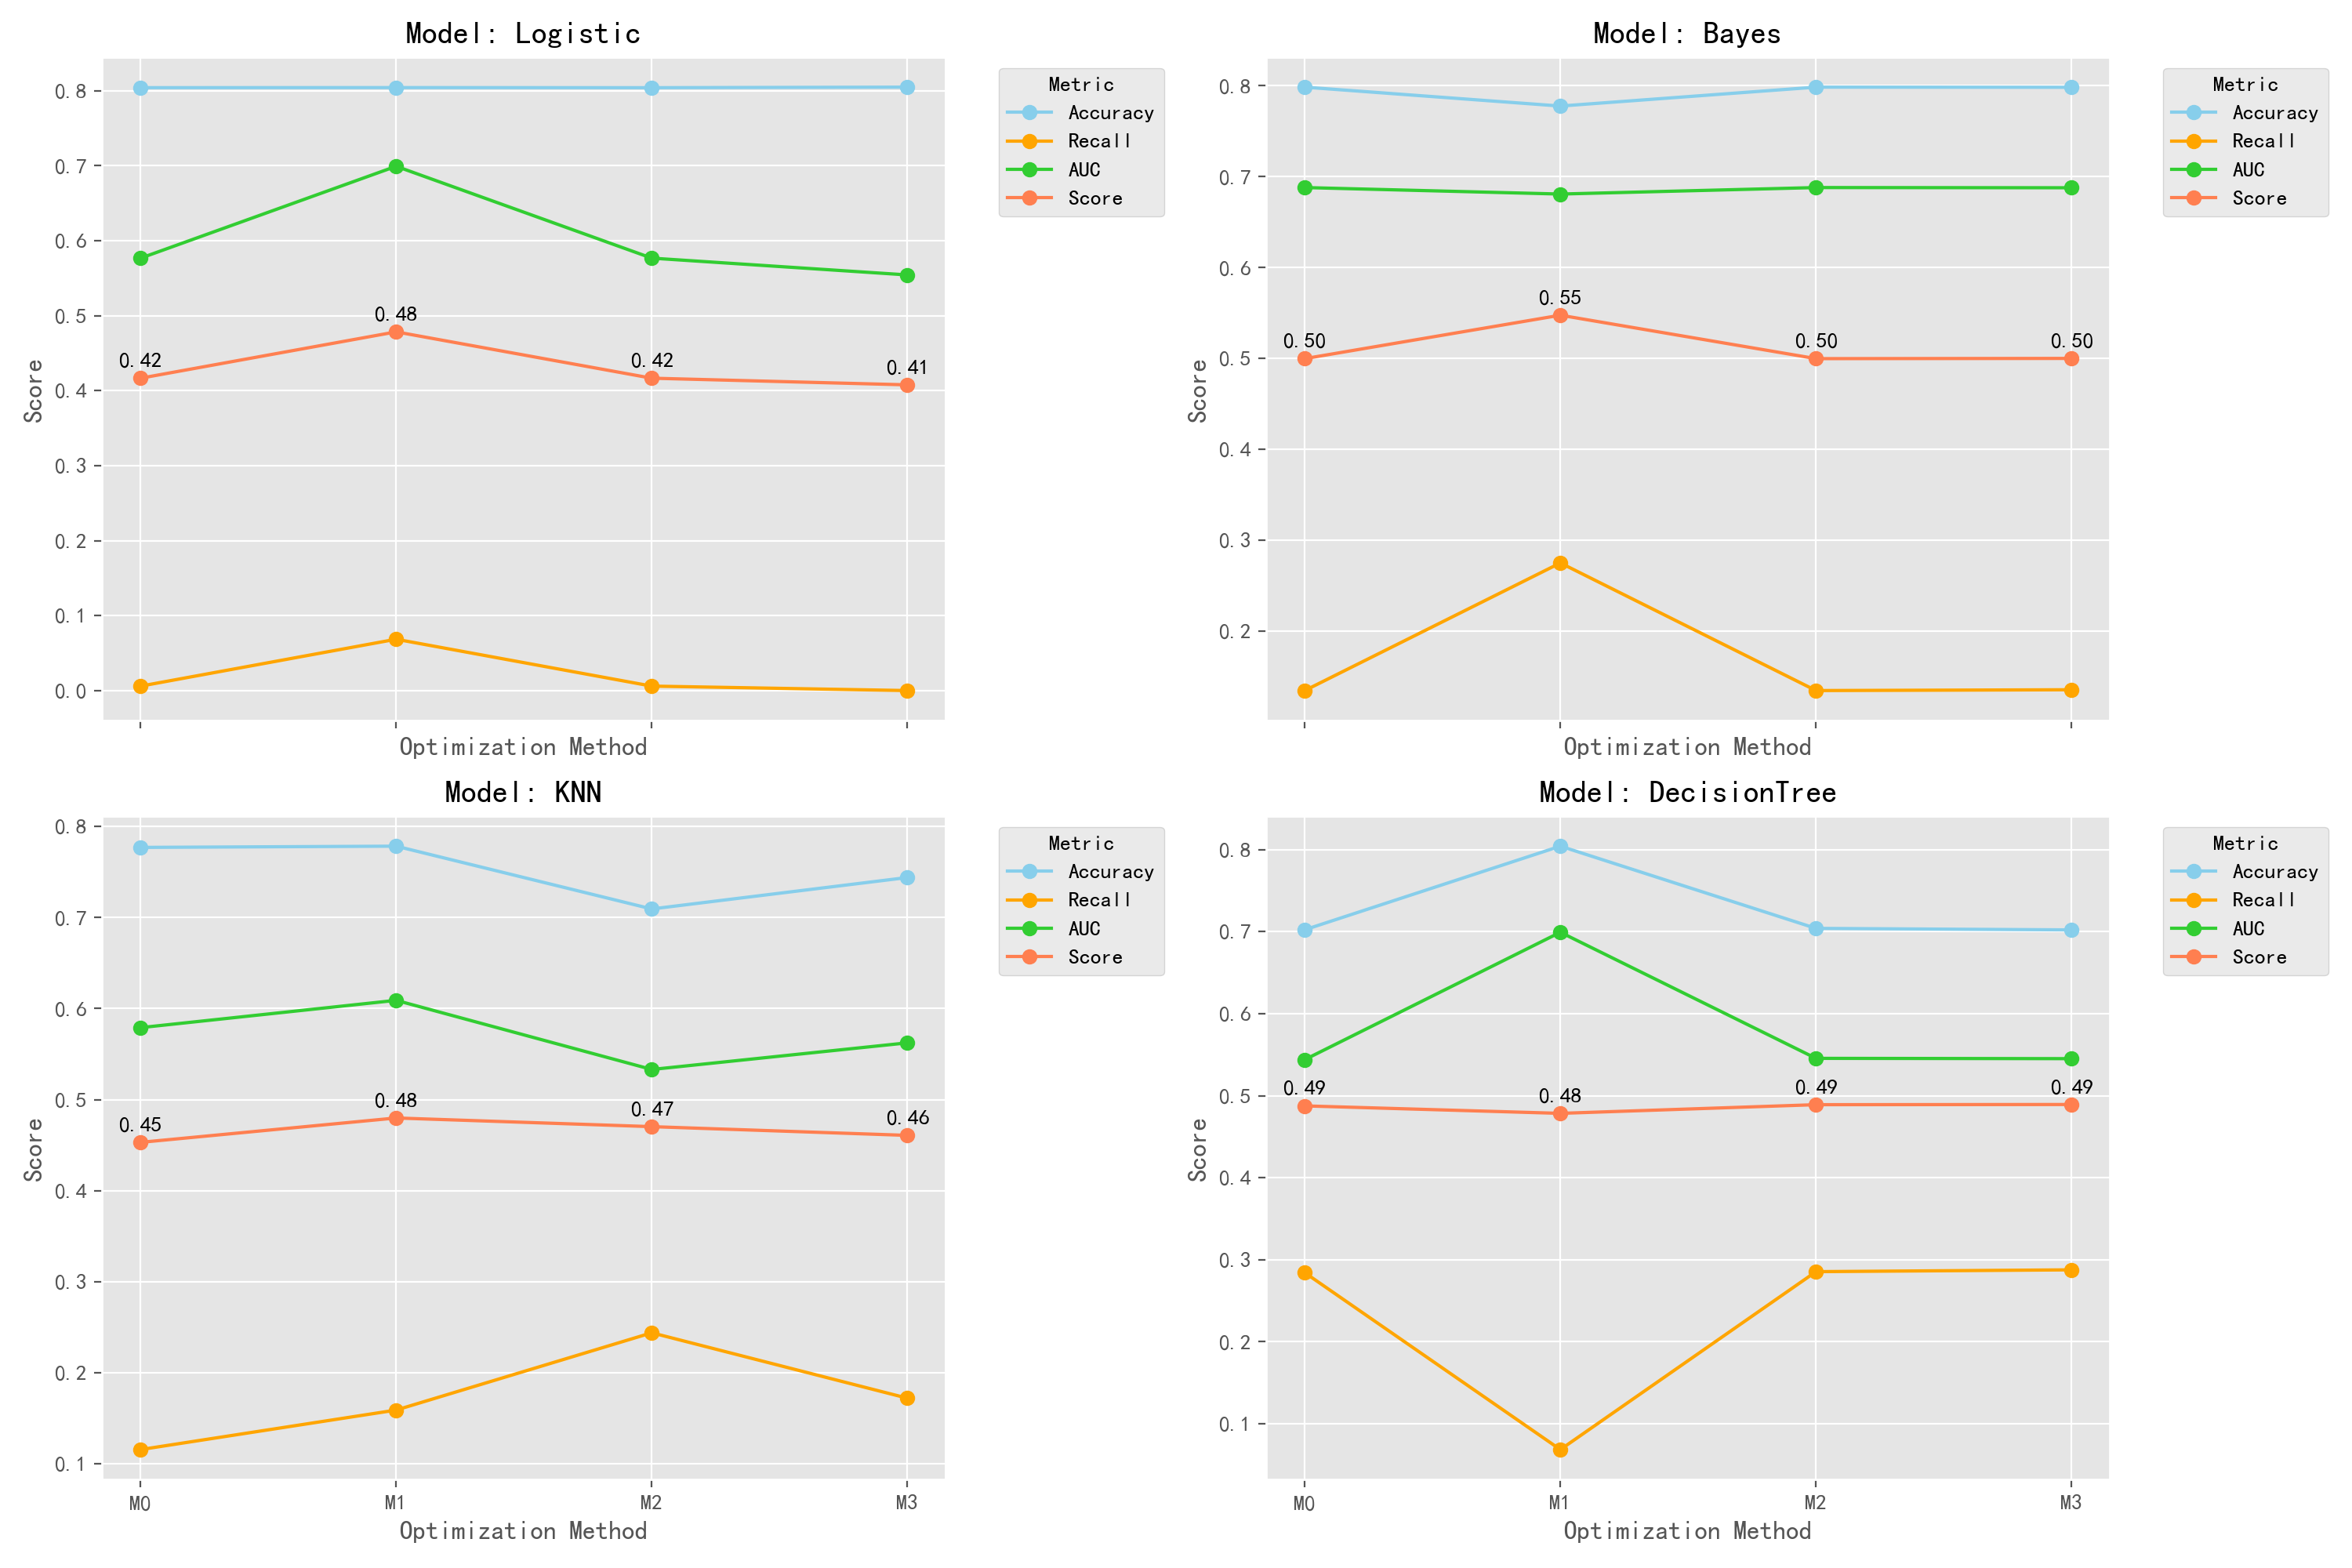

In [68]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_combined is recreated or loaded correctly
# ... (your DataFrame loading or recreation code here)

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)

# Define the optimization methods and the colors for each metric
optimizations = ['M0', 'M1', 'M2', 'M3']
metrics = ['Accuracy', 'Recall', 'AUC', 'Score']
metric_colors = ['skyblue', 'orange', 'limegreen', 'coral']

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each model and create a subplot
for idx, (ax, model) in enumerate(zip(axes, df_combined['Model'].unique())):
    model_data = df_combined[df_combined['Model'] == model]
    for metric, color in zip(metrics, metric_colors):
        scores = model_data[metric]
        ax.plot(optimizations, scores, marker='o', color=color, label=metric)
        
        # Add annotations only to the 'Score' metric
        if metric == 'Score':
            for (x, y) in zip(optimizations, scores):
                ax.annotate(f'{y:.2f}',  # Text to display
                            xy=(x, y),  # Position to start the text
                            xytext=(0, 5),  # Distance from text to points (x,y)
                            textcoords="offset points",  # Positioning text
                            ha='center')  # Horizontal alignment can be left, right or center
    
    ax.set_title(f'Model: {model}')
    ax.set_xlabel('Optimization Method')
    ax.set_ylabel('Score')
    # Positioning the legend outside the plot area
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to prevent overlapping and ensure everything fits
fig.tight_layout()
plt.savefig('plot10.png')
# Display the plot
plt.show()


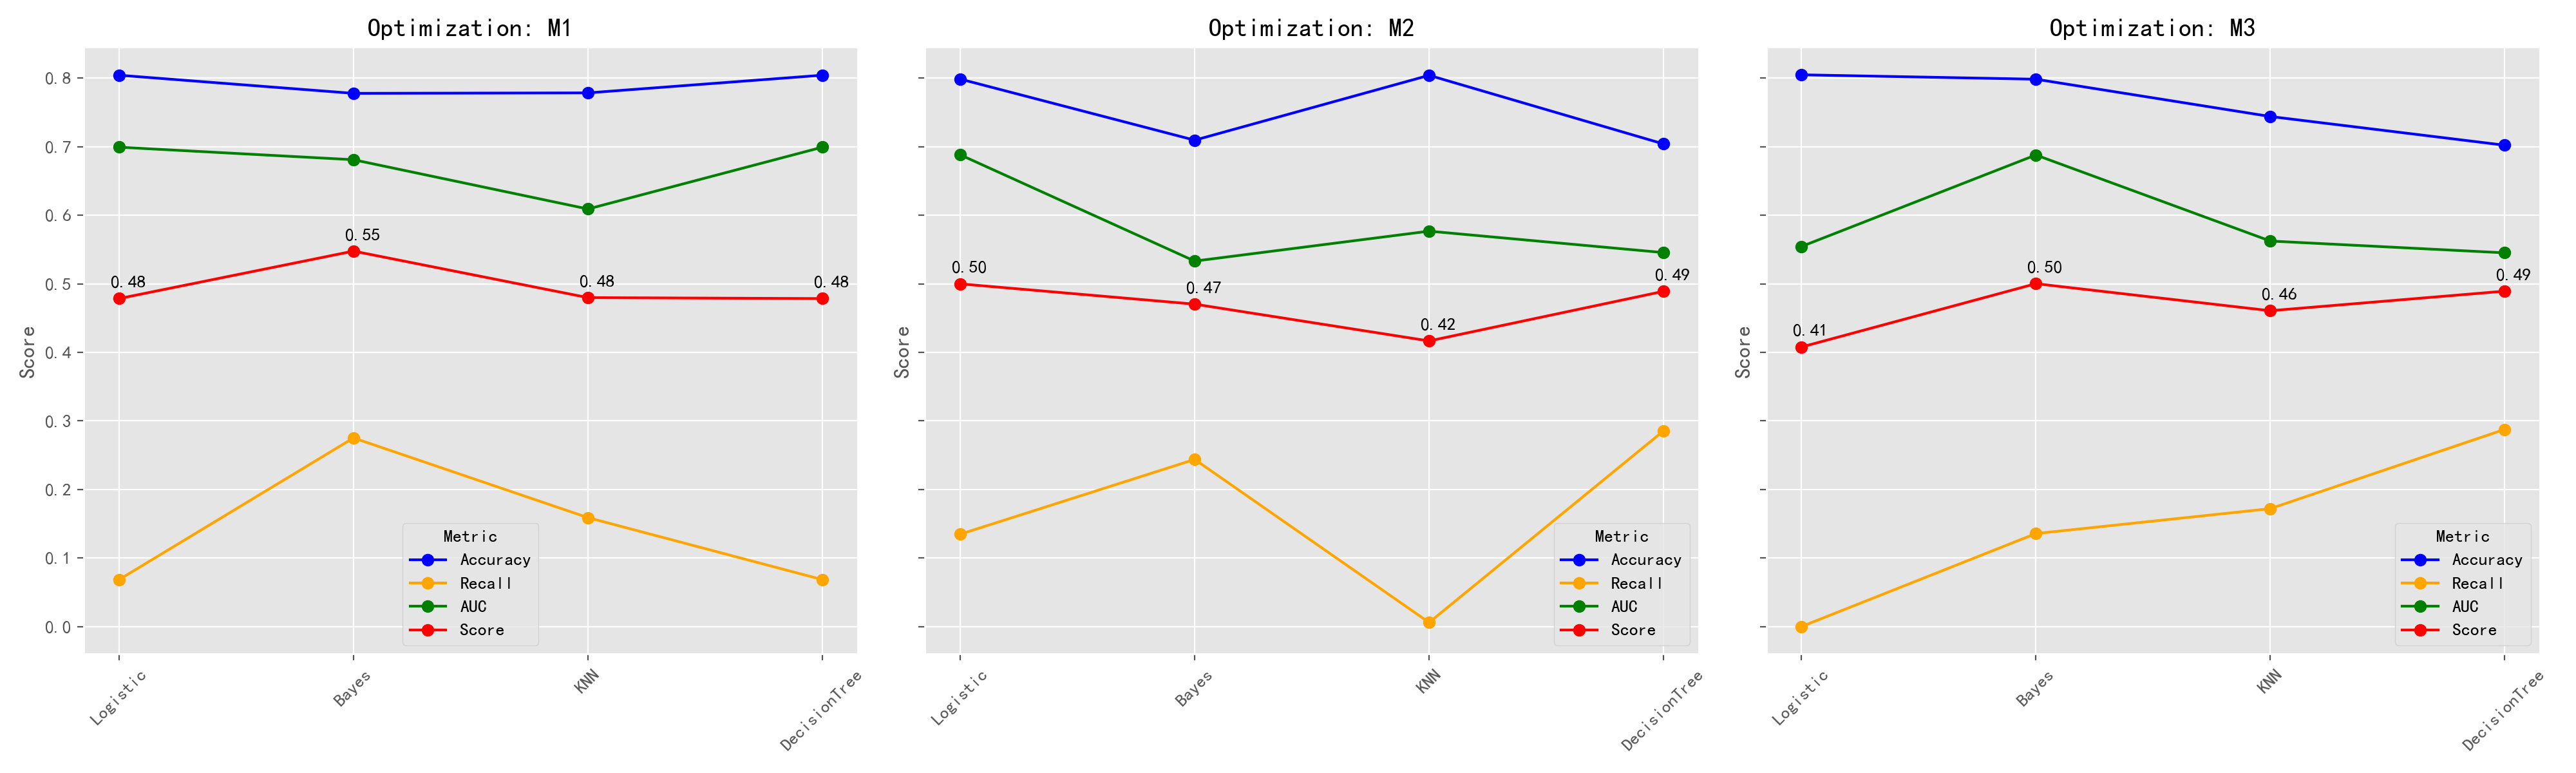

In [69]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

# Define the models and metrics
models = df_combined['Model'].unique()
metrics = ['Accuracy', 'Recall', 'AUC', 'Score']
metric_colors = ['blue', 'orange', 'green', 'red']  # Colors for each line in the subplots

# Plotting with adjusted annotations
for ax, optimization in zip(axes, ['M1', 'M2', 'M3']):  # Exclude M0 as it's the baseline
    opt_data = df_combined[df_combined['Optimization'] == optimization]
    for metric, color in zip(metrics, metric_colors):
        scores = opt_data[opt_data['Model'].isin(models)][metric]
        line, = ax.plot(models, scores, marker='o', color=color, label=metric)
        
        # Add annotations only to the 'Score' metric
        if metric == 'Score':
            for (x, y) in zip(models, scores):
                # Adjust the position of the annotation to be slightly above and to the right of the point
                ax.annotate(f'{y:.2f}', 
                            xy=(x, y), 
                            xytext=(5, 5),  # Shift the text slightly to the right and up
                            textcoords="offset points", 
                            ha='center', 
                            va='bottom')

    ax.set_title(f'Optimization: {optimization}')
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel('Score')
    ax.legend(title='Metric')

# Adjust the layout to prevent overlapping and ensure everything fits
fig.tight_layout()
plt.savefig("plot11.png")
# Display the plot
plt.show()
